### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import os, os.path
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import multivariate_normal
import scipy as sp

import pandas as pd

### Define Function for Later

In [2]:
def sample_data(N,dmean,dstd):
    D_N = np.zeros((N,dmean.shape[0]))
    for i in range(dmean.shape[0]):
        D_N[:,i] = np.random.normal(dmean[i], dstd[i], N)
    return D_N

# Import the Measured ERT Data

In [3]:
sfile = '../data/PH-2018-srv.txt'
efile = '../data/PH-2018-eloc.txt'
srv = pd.read_csv(sfile,sep='\t',header=None)
elec = pd.read_csv(efile,sep='\t',header=None)

M = (elec.values[srv.values[:,2][:].astype(int)-1,1]+elec.values[srv.values[:,4][:].astype(int)-1,1])/2
C = (elec.values[srv.values[:,1][:].astype(int)-1,3]+elec.values[srv.values[:,3][:].astype(int)-1,3])/2 - (elec.values[srv.values[:,4][:].astype(int)-1,1]-elec.values[srv.values[:,2][:].astype(int)-1,1])/2


### Plot Measured Data Mean and Standard Deviation

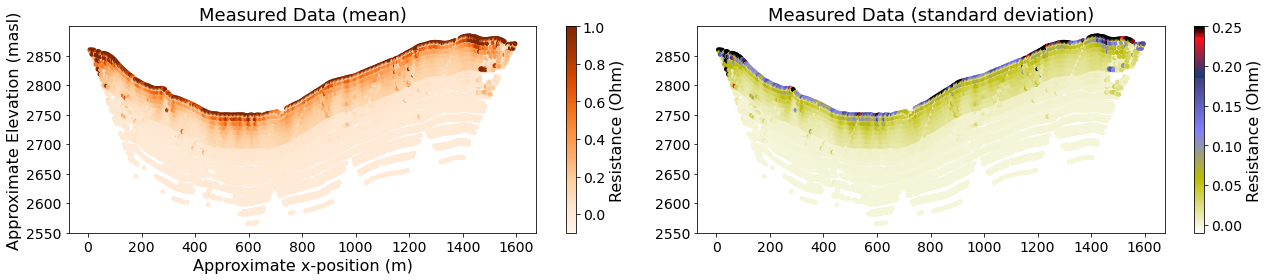

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

plt.subplot(121)
plt.scatter(M,C,15,c=srv.values[:,5],cmap='Oranges',vmin=-.1,vmax=1)
plt.title('Measured Data (mean)',fontsize=18)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14) 
cb.set_label(label='Resistance (Ohm)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Approximate x-position (m)',fontsize=16)
plt.ylabel('Approximate Elevation (masl)',fontsize=16)

plt.subplot(122)
plt.scatter(M,C,15,c=srv.values[:,6],cmap='gist_stern_r',vmax=.25,vmin=-.01)
plt.title('Measured Data (standard deviation)',fontsize=18)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14) 
cb.set_label(label='Resistance (Ohm)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.tight_layout()

# Import the Monte Carlo Data

In [5]:
MCfolder = '../data/MC3/'
rows = 11 # Number of header rows

In [6]:
pfile = MCfolder + 'params.dat'

files = [name for name in os.listdir(MCfolder) if (os.path.isfile(MCfolder+name) and (name != "params.dat"))]
Nreal = len(files)

In [7]:
D = np.zeros((Nreal,15371))
inds = np.zeros(Nreal,dtype=int)
i = 0
for f in files:
    data = ert.ERTManager(MCfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    D[i,:] = R
    f2 = f.split('_')[1]
    inds[i] = np.int(f2.split('.')[0])
    i = i+1


In [8]:
fullinput = pd.read_csv(pfile,skiprows=rows)
inputs = fullinput.values[inds,:]
fullinput

,dip,H,xpos,rho_fault,rho_back
0,101.833891,115.800812,412.011373,29.642176,49.316446
1,125.126511,174.696599,484.424341,27.897438,229.946475
2,109.386873,53.786238,456.523421,42.869513,72.535312
3,101.283646,126.145778,460.279214,26.864429,58.730871
4,84.311672,56.621057,432.695884,25.424708,68.864551
...,...,...,...,...,...
1995,135.779417,144.507231,406.534273,24.860789,84.199023
1996,125.967736,96.671548,375.001311,31.356123,81.066461
1997,92.215093,145.760068,370.331503,30.884901,85.394349
1998,115.140965,47.364446,405.448911,26.081312,205.104687


# Add Noise to the Monte Carlo ERT Data

In [9]:
DNoise = np.zeros(D.shape)       
for i in range(D.shape[0]):
    DNoise[i,:] = sample_data(1,D[i,:],srv.values[:,6])


In [10]:
itrain = np.int(np.round(.5 * inputs.shape[0]))

dmean = np.mean(DNoise[:itrain,:],axis=0)
dstd = np.std(DNoise[:itrain,:],axis=0)

DNew = (DNoise-dmean)/dstd

# Check out a Few Monte Carlo Realizations

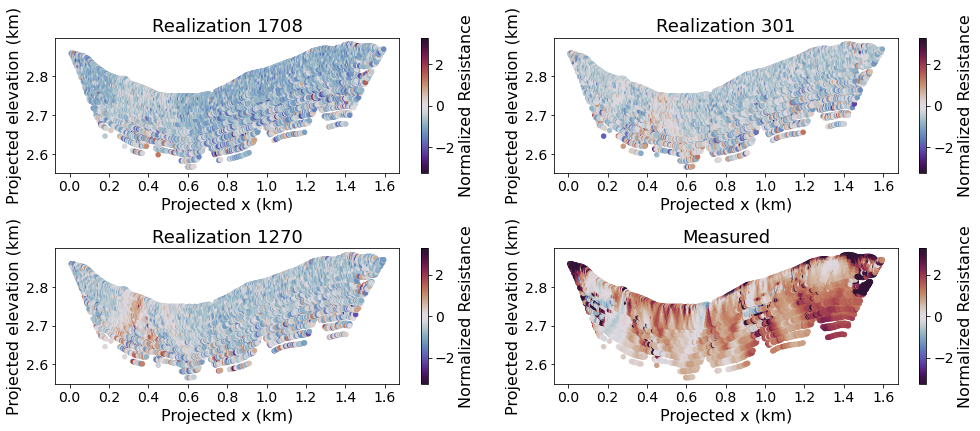

In [11]:
i = 120
cmap = 'twilight_shifted'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,6))
plt.subplot(221)
vmax = np.max(np.abs(DNew[i,:]))
# vmax = 4.5
plt.scatter(M/1000,C/1000,20,c=DNew[i,:],cmap=cmap,vmin=-vmax,vmax=vmax)
plt.title('Realization '+str(inds[i]),fontsize=18)
cb=plt.colorbar()
cb.set_label(label='Normalized Resistance',fontsize=16)
cb.ax.tick_params(labelsize=14) 
plt.xlabel('Projected x (km)',fontsize=16)
plt.ylabel('Projected elevation (km)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(222)
# vmax = np.max(np.abs(DNew[i+1,:]))
plt.scatter(M/1000,C/1000,20,c=DNew[i+1,:],cmap=cmap,vmin=-vmax,vmax=vmax)
plt.title('Realization '+str(inds[i+1]),fontsize=18)
cb=plt.colorbar()
cb.set_label(label='Normalized Resistance',fontsize=16)
cb.ax.tick_params(labelsize=14) 
plt.xlabel('Projected x (km)',fontsize=16)
plt.ylabel('Projected elevation (km)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(223)
# vmax = np.max(np.abs(DNew[i+2,:]))
plt.scatter(M/1000,C/1000,20,c=DNew[i+2,:],cmap=cmap,vmin=-vmax,vmax=vmax)
plt.title('Realization '+str(inds[i+2]),fontsize=18)
cb=plt.colorbar()
cb.set_label(label='Normalized Resistance',fontsize=16)
cb.ax.tick_params(labelsize=14) 
plt.xlabel('Projected x (km)',fontsize=16)
plt.ylabel('Projected elevation (km)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(224)
# vmax = np.max(np.abs((srv.values[:,5]-dmean)/dstd))
plt.scatter(M/1000,C/1000,20,c=(srv.values[:,5]-dmean)/dstd,cmap=cmap,vmin=-vmax,vmax=vmax)
plt.title('Measured',fontsize=18)
cb=plt.colorbar()
cb.set_label(label='Normalized Resistance',fontsize=16)
cb.ax.tick_params(labelsize=14) 
plt.xlabel('Projected x (km)',fontsize=16)
plt.ylabel('Projected elevation (km)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


fig.tight_layout()

# Sample Measurement Realizations

# Do PCA

In [13]:
pca = PCA()
pca.fit(DNew)

S_pc = PCA().fit_transform(DNew)

In [14]:
#Transform measured data into PC space
data = (srv.values[:,5]-dmean)/dstd #normalizing measured data
S_real = pca.transform(data.reshape(1,-1))
D_trans = pca.inverse_transform(S_real)


(10000, 1936)

# Scree Plot

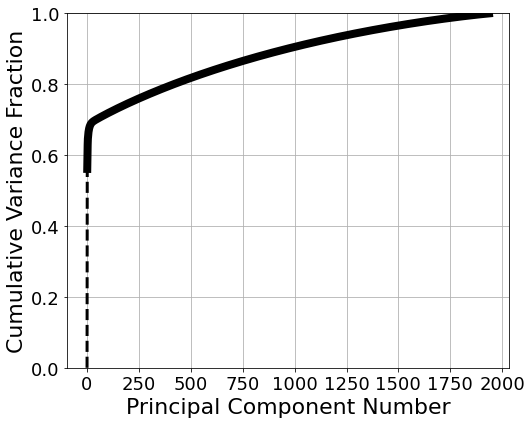

In [31]:
lblsize = 22
ticksize = 18

npcs = 1936
pc = list(range(1,npcs+1))

# variance =  np.concatenate((np.array([0]),np.cumsum(pca.explained_variance_ratio_[0:npcs])))
variance = np.cumsum(pca.explained_variance_ratio_[0:npcs])

plt.figure(figsize=(7.5,6))
plt.plot(pc,variance,'-k',linewidth=8)
plt.plot([0,1],[0,variance[0]],'--k',linewidth=3)
plt.ylim((0,1))
plt.xlabel('Principal Component Number',fontsize=lblsize)
plt.ylabel('Cumulative Variance Fraction',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

plt.tight_layout()

# Plot the First Few Eigenvectors/Principal Components

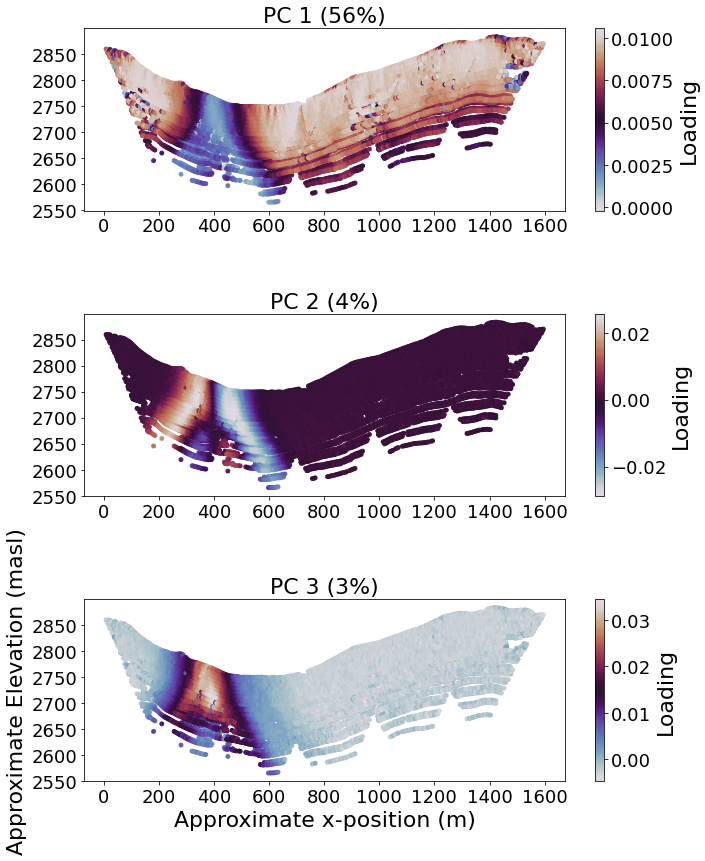

In [25]:


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
plt.subplot(311)
plt.scatter(M,C,15,c=pca.components_[0,:],cmap='twilight')
plt.title('PC 1 ('+str(int(np.round(pca.explained_variance_ratio_[0]*100)))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.subplot(312)
plt.scatter(M,C,15,c=pca.components_[1,:],cmap='twilight')
plt.title('PC 2 ('+str(int(np.round(pca.explained_variance_ratio_[1]*100)))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.subplot(313)
plt.scatter(M,C,15,c=pca.components_[2,:],cmap='twilight')
plt.title('PC 3 ('+str(int(np.round(pca.explained_variance_ratio_[2]*100)))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlabel('Approximate x-position (m)',fontsize=lblsize)
plt.ylabel('Approximate Elevation (masl)',fontsize=lblsize)

fig.tight_layout()

# Scores for First Four Principal Components

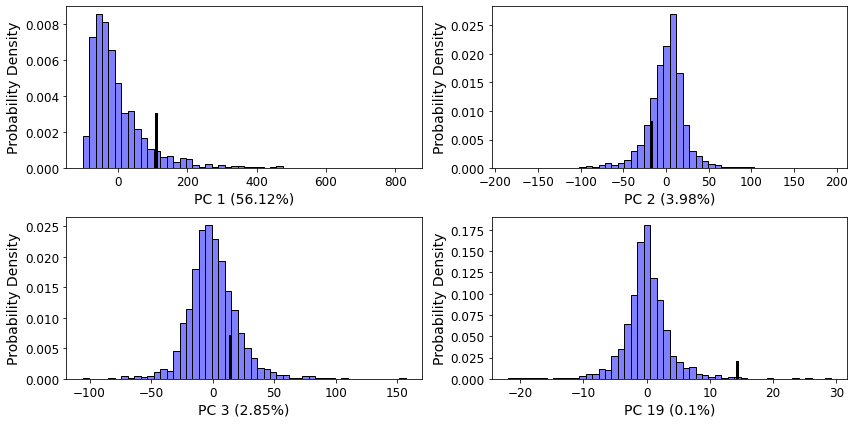

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,6))

plt.subplot(221)
r = 0;
plt.hist(S_pc[:,r],50,density=True,facecolor=(.5,.5,1),edgecolor='k',label='Prior')
plt.plot([S_real[0][r],S_real[0][r]], [0,.003],'-k',linewidth=3,label='Measured')
plt.xlabel('PC '+str(r+1)+' ('+str(np.round(pca.explained_variance_ratio_[r]*100,2))+'%)',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(222)
r = 1;
plt.hist(S_pc[:,r],50,density=True,facecolor=(.5,.5,1),edgecolor='k',label='Prior')
plt.plot([S_real[0][r],S_real[0][r]], [0,.008],'-k',linewidth=3,label='Measured')
plt.xlabel('PC '+str(r+1)+' ('+str(np.round(pca.explained_variance_ratio_[r]*100,2))+'%)',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(223)
r = 2;
plt.hist(S_pc[:,r],50,density=True,facecolor=(.5,.5,1),edgecolor='k',label='Prior')
plt.plot([S_real[0][r],S_real[0][r]], [0,.007],'-k',linewidth=3,label='Measured')
plt.xlabel('PC '+str(r+1)+' ('+str(np.round(pca.explained_variance_ratio_[r]*100,2))+'%)',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(224)
r = 18;
plt.hist(S_pc[:,r],50,density=True,facecolor=(.5,.5,1),edgecolor='k',label='Prior')
plt.plot([S_real[0][r],S_real[0][r]], [0,.02],'-k',linewidth=3,label='Measured')
plt.xlabel('PC '+str(r+1)+' ('+str(np.round(pca.explained_variance_ratio_[r]*100,2))+'%)',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


fig.tight_layout()

# Score Cross Plot with Measured Data

01/04/21 - 14:45:32 - matplotlib.axes._axes - WARNING - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
01/04/21 - 14:45:32 - matplotlib.axes._axes - WARNING - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


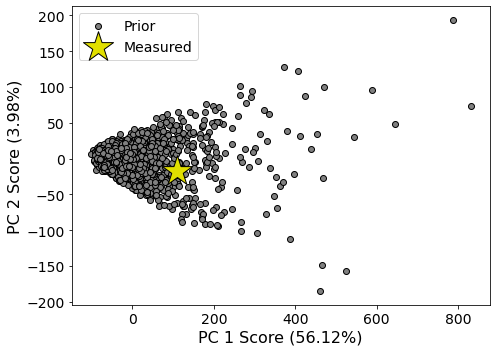

In [18]:
r=0
plt.figure(figsize=(7,5))
plt.scatter(S_pc[:,r],S_pc[:,r+1],c=(0.5,0.5,0.5),edgecolor='k',label='Prior')
plt.scatter(S_real[0][r],S_real[0][r+1],1000,marker='*',edgecolor='k',c=(225/255,223/255,0/255),label='Measured')
# plt.scatter(S_pc[i+2,r],S_pc[i+2,r+1],500,c=(0,0,0.75),label='Prior')

plt.xlabel('PC '+str(r+1)+' Score ('+str(np.round(pca.explained_variance_ratio_[r]*100,2))+'%)',fontsize=16)
plt.ylabel('PC '+str(r+2)+' Score ('+str(np.round(pca.explained_variance_ratio_[r+1]*100,2))+'%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.tight_layout()

# Box Plots of Scores

Cumulative Variance of First 10 PCs: 67.52%


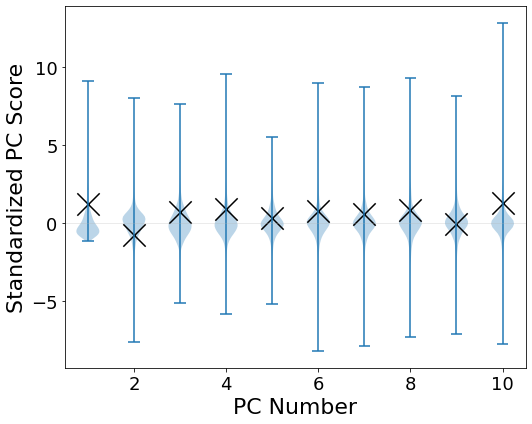

In [26]:
npc = 10

S_mean = np.mean(S_pc,axis=0)
S_std = np.std(S_pc,axis=0)
S_norm = (S_pc-S_mean)/S_std
S_real_norm = (S_real[0]-S_mean)/S_std


xs = np.array(list(range(npc)))+1

fig = plt.figure(figsize=(7.5,6))
plt.violinplot(S_norm[:,:npc])
plt.scatter(xs, S_real_norm[:npc], 5000/npc, marker='x',color='k')
plt.ylabel('Standardized PC Score',fontsize=lblsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.xlabel('PC Number',fontsize=lblsize)
plt.xlim([0.5,npc+0.5])
plt.axhline(0,linewidth=1,color=[.7,.7,.7,.25]) # horizontal lines
# plt.title('Cumulative Variance of First '+str(npc)+' PCs: '+str(np.round(variance[npc-1]*100,2))+'%',fontsize=20)
print('Cumulative Variance of First '+str(npc)+' PCs: '+str(np.round(variance[npc-1]*100,2))+'%')

# axs[1].violinplot(S_pc[:,1:npc])
# axs[1].scatter(xs[1:]-1, S_real[0][1:npc],5000/npc, marker='x',color='k')
# axs[1].set_xlabel('PC Number',fontsize=18)
# axs[1].set_xlim([0,npc])
# axs[1].tick_params(axis='both', which='major', labelsize=14)
# axs[1].set_title('Variance Explained: '+str(np.round(variance[npc-1]*100,2))+'%',fontsize=20)

plt.tight_layout()

Number of Measured PCs Outside Prior: 20


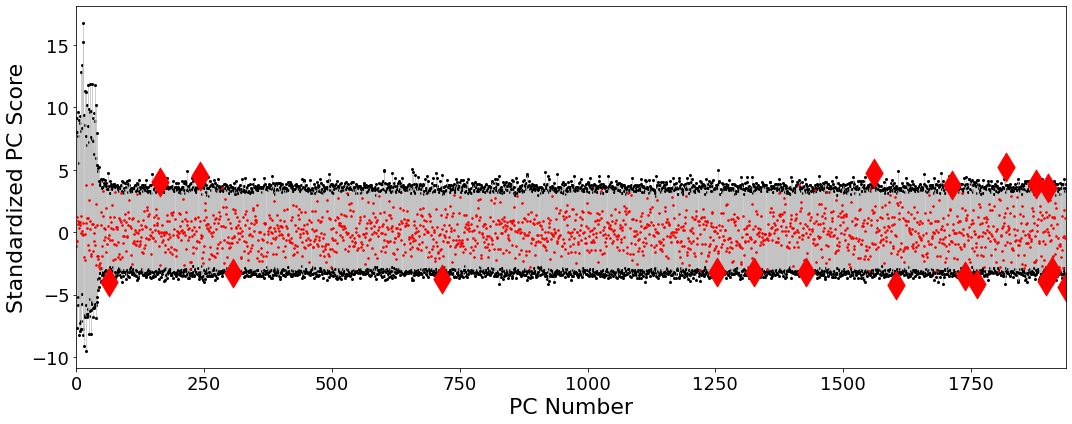

In [30]:
npc = 1935

S_mean = np.mean(S_pc,axis=0)
S_std = np.std(S_pc,axis=0)
S_norm = (S_pc-S_mean)/S_std
S_real_norm = (S_real[0]-S_mean)/S_std


xs = np.array(list(range(npc)))+1

inds_out = (S_real_norm > np.max(S_norm,axis=0)) | (S_real_norm < np.min(S_norm,axis=0))
inds_in = ~inds_out

fig = plt.figure(figsize=(15,6))
# plt.violinplot(S_norm[:,:npc])
for i in range(npc):
    plt.plot([xs[i],xs[i]],[np.min(S_norm[:,i]), np.max(S_norm[:,i])],'.-',color=[.75,.75,.75,.75],linewidth=1,markerfacecolor='k',markeredgecolor='k',markersize=4,zorder=1)
# plt.scatter(xs, S_real_norm[:npc], 100000/npc, marker='o',color='r')
plt.scatter(xs[:npc][inds_out[:npc]], S_real_norm[:npc][inds_out[:npc]], 800000/npc, marker='d',color='r',zorder=2)
plt.scatter(xs[:npc][inds_in[:npc]], S_real_norm[:npc][inds_in[:npc]], 5000/npc, marker='o',color='r',zorder=3)

plt.ylabel('Standardized PC Score',fontsize=lblsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.xlabel('PC Number',fontsize=lblsize)
plt.xlim([0,npc])
# plt.title('Number of Measured PCs Outside Prior: '+str(sum(inds_out)),fontsize=20)
print('Number of Measured PCs Outside Prior: '+str(sum(inds_out)))

plt.tight_layout()

# Cross Plots

r^2 = 0.9914012794285036


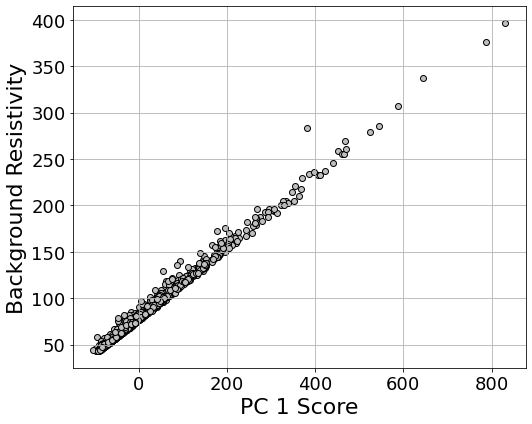

In [48]:
plt.figure(figsize=(7.5,6))
plt.scatter(S_pc[:,0],inputs[:,4],color=[0.75,0.75,0.75],edgecolor='k')
plt.xlabel('PC 1 Score',fontsize=lblsize)
plt.ylabel('Background Resistivity (Ohm-m)',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

print('r^2 = '+str(np.corrcoef(S_pc[:,0],inputs[:,4])[0,1]**2))
plt.tight_layout()

r^2 = 0.4311965194223617


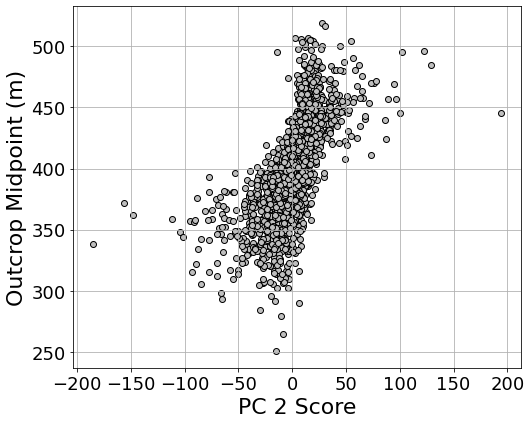

In [76]:
v = 2
pc = 1

plt.figure(figsize=(7.5,6))
plt.scatter(S_pc[:,pc],inputs[:,v],color=[0.75,0.75,0.75],edgecolor='k')
plt.xlabel('PC 2 Score',fontsize=lblsize)
plt.ylabel('Outcrop Midpoint (m)',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

print('r^2 = '+str(np.corrcoef(S_pc[:,pc],inputs[:,v])[0,1]**2))
plt.tight_layout()

r^2 = 0.29793038828101764


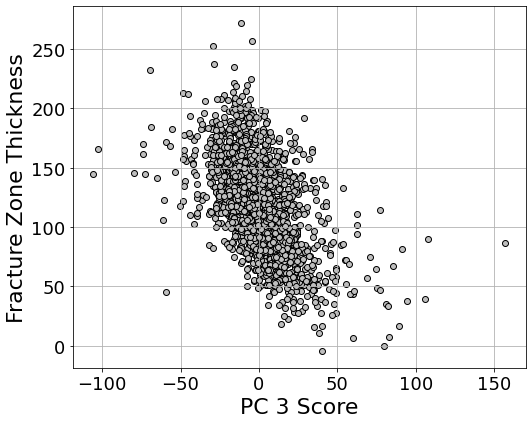

In [73]:
v = 1
pc = 2

plt.figure(figsize=(7.5,6))
plt.scatter(S_pc[:,pc],inputs[:,v],color=[0.75,0.75,0.75],edgecolor='k')
plt.xlabel('PC 3 Score',fontsize=lblsize)
plt.ylabel('Fracture Zone Thickness (m)',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

print('r^2 = '+str(np.corrcoef(S_pc[:,pc],inputs[:,v])[0,1]**2))
plt.tight_layout()

r^2 = 0.1663729700285069


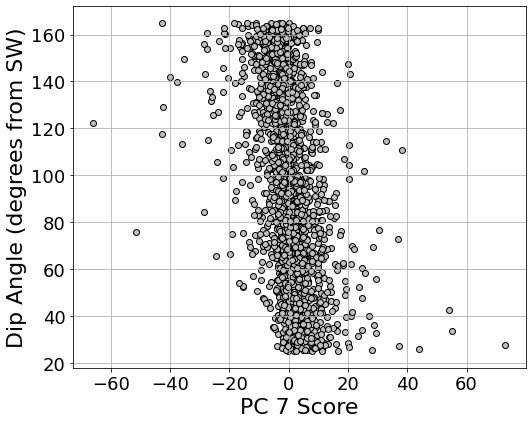

In [100]:
v = 0
pc = 6 #6, 8

plt.figure(figsize=(7.5,6))
plt.scatter(S_pc[:,pc],inputs[:,v],color=[0.75,0.75,0.75],edgecolor='k')
plt.xlabel('PC 7 Score',fontsize=lblsize)
plt.ylabel('Dip Angle (degrees from SW)',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

print('r^2 = '+str(np.corrcoef(S_pc[:,pc],inputs[:,v])[0,1]**2))
plt.tight_layout()

r^2 = 0.20306257311688297


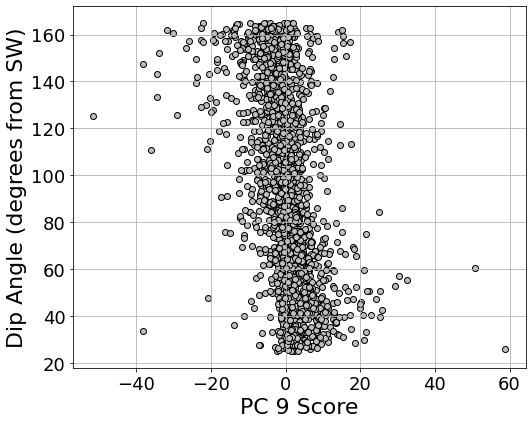

In [102]:
v = 0
pc = 8 #6, 8

plt.figure(figsize=(7.5,6))
plt.scatter(S_pc[:,pc],inputs[:,v],color=[0.75,0.75,0.75],edgecolor='k')
plt.xlabel('PC 9 Score',fontsize=lblsize)
plt.ylabel('Dip Angle (degrees from SW)',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.grid()

print('r^2 = '+str(np.corrcoef(S_pc[:,pc],inputs[:,v])[0,1]**2))
plt.tight_layout()

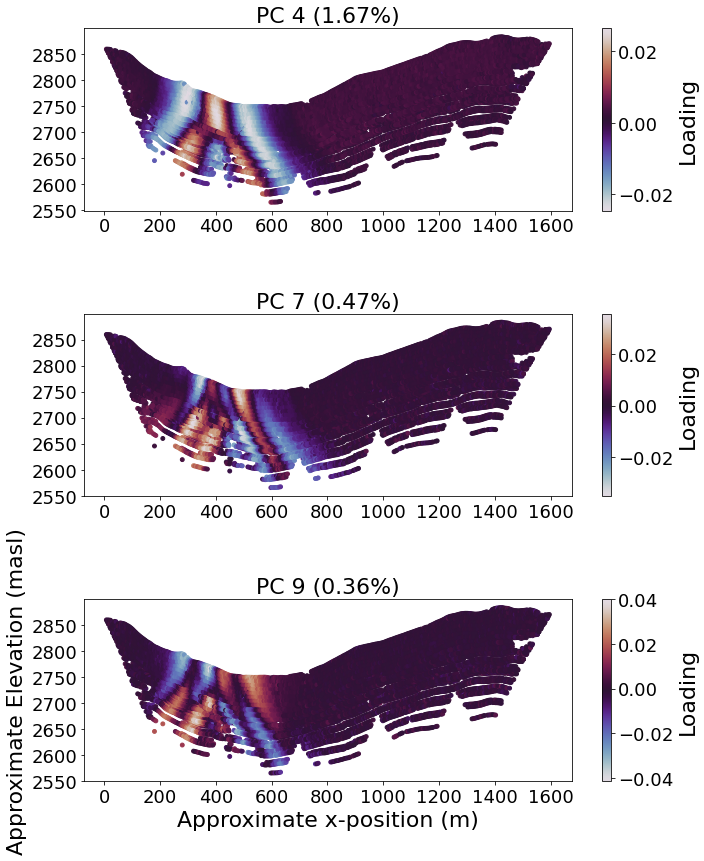

In [105]:


fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
plt.subplot(311)
plt.scatter(M,C,15,c=pca.components_[3,:],cmap='twilight')
plt.title('PC 4 ('+str(np.round(pca.explained_variance_ratio_[3]*100,2))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.subplot(312)
plt.scatter(M,C,15,c=pca.components_[6,:],cmap='twilight')
plt.title('PC 7 ('+str(np.round(pca.explained_variance_ratio_[6]*100,2))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

plt.subplot(313)
plt.scatter(M,C,15,c=pca.components_[8,:],cmap='twilight')
plt.title('PC 9 ('+str(np.round(pca.explained_variance_ratio_[8]*100,2))+'%)',fontsize=lblsize)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=ticksize) 
cb.set_label(label='Loading',fontsize=lblsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.xlabel('Approximate x-position (m)',fontsize=lblsize)
plt.ylabel('Approximate Elevation (masl)',fontsize=lblsize)

fig.tight_layout()